<a href="https://colab.research.google.com/github/Quantyca/demo-ateam-ai-misc/blob/master/image-processing/protein-eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Protein: eval


##  Intro

**Problem type:** Multi-label prediction with Human Protein Atlas Image Dataset

**Dataset:** [Human Protein Atlas Image Classification from Kaggle](https://www.kaggle.com/c/human-protein-atlas-image-classification)

## Set env

In [0]:
!pip list | grep fastai

fastai                   1.0.52               


In [0]:
!rm -fR sample_data

In [0]:
!pwd && ls -l

/content
total 12
drwxr-xr-x 2 root root 4096 Jun  8 20:43 data
drwxr-xr-x 2 root root 4096 Jun  8 20:43 models
drwxr-xr-x 2 root root 4096 Jun  8 20:44 protein


## Import libs

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.utils.collect_env import *

In [0]:
show_install(True)



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.52
fastprogress  : 0.1.21
torch         : 1.1.0
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7501 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Sat Jun  8 20:43:39 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+--------

We set random seed for reproducibility

In [0]:
np.random.seed(42)

## Set up data env

Let's download the datset from kaggle ...

In [0]:
#! pip install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Now we can upload the kaggle.json file on colab

In [0]:
# from google.colab import files
# uploaded = files.upload()

In [0]:
_=download_url('https://storage.googleapis.com/ml_quantyca_it/personal/andrea/kaggle.json','./kaggle.json', overwrite=False)

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

You're all set to download the data from [Human Protein Atlas Image Classification Competition](https://www.kaggle.com/c/human-protein-atlas-image-classification). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [0]:
PROJECT_NAME = 'protein'

In [0]:
PATH = Path(PROJECT_NAME)
PATH.mkdir(parents=True, exist_ok=True)

In [0]:
! ls -l 

total 12
drwxr-xr-x 2 root root 4096 Jun  8 20:43 data
drwxr-xr-x 2 root root 4096 Jun  8 20:43 models
drwxr-xr-x 2 root root 4096 Jun  8 20:44 protein


In [0]:
DATA_PATH = Path(PATH/'data')
DATA_PATH.mkdir(parents=True, exist_ok=True)
DATA_PATH

PosixPath('protein/data')

In [0]:
MODEL_PATH = Path(PATH/'models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_PATH

PosixPath('protein/models')

In [0]:
! ls -l  {PATH}

total 8
drwxr-xr-x 2 root root 4096 Jun  8 20:45 data
drwxr-xr-x 2 root root 4096 Jun  8 20:45 models


## Eval on validation

Download data (13 GB; estimated time 10min)

In [0]:
! kaggle competitions download -c human-protein-atlas-image-classification -f train.zip -p {DATA_PATH}  
! kaggle competitions download -c human-protein-atlas-image-classification -f train.csv -p {DATA_PATH}  

100% 13.1G/13.1G [08:22<00:00, 30.8MB/s]
100% 13.1G/13.1G [08:22<00:00, 28.0MB/s]
  0% 0.00/1.22M [00:00<?, ?B/s]
100% 1.22M/1.22M [00:00<00:00, 82.3MB/s]


In [0]:
TRAIN_PATH = DATA_PATH/'train'

In [0]:
! unzip -q -n {DATA_PATH}/train.zip -d {TRAIN_PATH}

In [0]:
! ls  {TRAIN_PATH} | head
! ls  {TRAIN_PATH} | wc -l

00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_green.png
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_red.png
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_blue.png
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_green.png
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_red.png
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_blue.png
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_green.png
124288


In [0]:
train_files = list(Path(TRAIN_PATH).iterdir())
print('Tot files: {} ({})'.format(len(train_files), len(train_files)/4))
train_items  = list(filter(lambda x: str(x).endswith('_green.png'), train_files))
print('Tot items: {} ({} - {})'.format(len(train_items), .8*len(train_items), .2*len(train_items)))


Tot files: 124288 (31072.0)
Tot items: 31072 (24857.600000000002 - 6214.400000000001)


Create DataBunch

In [0]:
df = pd.read_csv(DATA_PATH/'train.csv')
print('Label set shape: {}'.format(df.shape))
df.head() 

Label set shape: (31072, 2)


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
src = (ImageList.from_csv(DATA_PATH, 'train.csv', folder='train', suffix='_green.png')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

In [0]:
print('Train items: ', len(data.train_dl.dl.dataset))
print('Valid items: ', len(data.valid_dl.dl.dataset))
print('Valid perc: ', len(data.valid_dl.dl.dataset)/len(data.train_dl.dl.dataset))


Train items:  24858
Valid items:  6214
Valid perc:  0.24997988575106606


Create learner

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f1_score = partial(fbeta, thresh=0.2, beta=1)
f2_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f2_score, f1_score], pretrained=False)

In [0]:
# from google.colab import files
# uploaded = files.upload()

In [0]:
# ! mv stage-2-256-rn50.pth /root/.fastai/data/protein/models/stage-2-256-rn50.pth

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
# !cp /content/gdrive/My\ Drive/Quantyca/Quantyca\ -\ Colab\ Notebooks/andrea/stage-2-256-rn50.pth {path}/models/stage-2-256-rn50.pth 

In [0]:
#! mkdir -p ./data/protein/models

In [0]:
_=download_url('https://storage.googleapis.com/ml_quantyca_it/personal/andrea/protein/models/stage-2-256-rn50.pth', MODEL_PATH/'stage-2-256-rn50.pth', overwrite=False)

In [0]:
#_=download_url('https://storage.googleapis.com/ml_quantyca_it/personal/andrea/protein/models/protein4c-stg-2-rn50.pth', MODEL_PATH/'protein4c-stg-2-rn50.pth', overwrite=False)

In [0]:
! ls -l {MODEL_PATH}

total 601420
-rw-r--r-- 1 root root 307944396 Jun  8 21:05 protein4c-stg-2-rn50.pth
-rw-r--r-- 1 root root 307906891 Jun  8 21:07 stage-2-256-rn50.pth


In [0]:
learn.model_dir = '../models'

In [0]:
learn.load('stage-2-256-rn50')
#learn.load('protein4c-stg-2-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (24858 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
16;0,7;1;2;0,5,1,18
Path: protein/data;

Valid: LabelList (6214 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
4,25;4,7,7;5,20;2;0
Path: protein/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (c

In [0]:
results = learn.validate(dl=learn.data.valid_dl)

In [0]:
results

[0.07630694, tensor(0.9644), tensor(0.7816), tensor(0.7391)]

In [0]:
learn.export(file="../models/protein.pkl")

In [0]:
! ls {MODEL_PATH}

protein4c-stg-2-rn50.pth  protein.pkl  stage-2-256-rn50.pth


##  Eval on test

In [0]:
! kaggle competitions download -c human-protein-atlas-image-classification -f test.zip -p {DATA_PATH} 
! kaggle competitions download -c human-protein-atlas-image-classification -f sample_submission.csv -p {DATA_PATH} 

100% 4.36G/4.37G [01:43<00:00, 26.5MB/s]
100% 4.37G/4.37G [01:43<00:00, 45.1MB/s]
  0% 0.00/446k [00:00<?, ?B/s]
100% 446k/446k [00:00<00:00, 63.5MB/s]


In [0]:
TEST_PATH = DATA_PATH/'test'

In [0]:
! unzip -q -n {DATA_PATH}/test.zip -d {TEST_PATH}

In [0]:
! ls  {TEST_PATH} | head


00008af0-bad0-11e8-b2b8-ac1f6b6435d0_blue.png
00008af0-bad0-11e8-b2b8-ac1f6b6435d0_green.png
00008af0-bad0-11e8-b2b8-ac1f6b6435d0_red.png
00008af0-bad0-11e8-b2b8-ac1f6b6435d0_yellow.png
0000a892-bacf-11e8-b2b8-ac1f6b6435d0_blue.png
0000a892-bacf-11e8-b2b8-ac1f6b6435d0_green.png
0000a892-bacf-11e8-b2b8-ac1f6b6435d0_red.png
0000a892-bacf-11e8-b2b8-ac1f6b6435d0_yellow.png
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0_blue.png
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0_green.png


In [0]:
test_files = list(Path(TEST_PATH).iterdir())
print('Tot files: {} ({})'.format(len(test_files), len(test_files)/4))
test_items  = list(filter(lambda x: str(x).endswith('_green.png'), test_files))
print('Tot items: {} ({} - {})'.format(len(test_items), .8*len(test_items), .2*len(test_items)))

Tot files: 46808 (11702.0)
Tot items: 11702 (9361.6 - 2340.4)


In [0]:
! head -n 10 {DATA_PATH}/sample_submission.csv
! wc -l {DATA_PATH}/sample_submission.csv

Id,Predicted
00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0
00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,0
001765de-bacd-11e8-b2b8-ac1f6b6435d0,0
0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0
00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0
11703 protein/data/sample_submission.csv


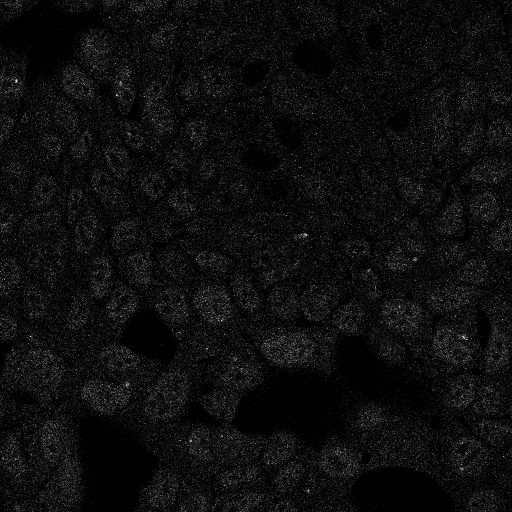

In [0]:
files = list(TEST_PATH.glob('*_green.png'))
img = open_image(files[0])
img

In [0]:
learn_inference = load_learner(path=MODEL_PATH, file="protein.pkl")

In [0]:
files = list(TEST_PATH.glob('*_green.png'))
str(files[0]).replace("protein/data/test/", '')

'ab71cdbe-bac5-11e8-b2b7-ac1f6b6435d0_green.png'

In [0]:
files = list(TEST_PATH.glob('*_green.png'))

out = open(DATA_PATH/'submission.csv', 'w')
out.write('Id,Predicted\n')

i = 0;
n = 0;
for f in files:
  img = open_image(files[i])
  preds = learn_inference.predict(img)
  f = str(f).replace("protein/data/test/", '').replace("_green.png", '')
  l = str(preds[0]).replace(';', ' ')
  if l == '': n = n+1
  #print("{},{},{}".format(n, f, l ))
  out.write("{},{}\n".format(f, l )) 
  i = i + 1
  #if i > 15 : break

out.close()

In [0]:
sample_df = pd.read_csv(DATA_PATH/'sample_submission.csv')
print('Label set shape: {}'.format(sample_df.shape))
sample_df.head() 

Label set shape: (11702, 2)


,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0


In [0]:
sample_list = list(sample_df.Id)
len(sample_list), sample_list[:5]

(11702,
 ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0',
  '0000a892-bacf-11e8-b2b8-ac1f6b6435d0',
  '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0',
  '0008baca-bad7-11e8-b2b9-ac1f6b6435d0',
  '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0'])

In [0]:
ids = sample_list

out = open(DATA_PATH/'submission.csv', 'w')
out.write('Id,Predicted\n')

i = 0;
n = 0;
for id in ids:
  file_name = id + '_green.png';
  img = open_image(TEST_PATH/file_name)
  preds = learn_inference.predict(img)
  l = str(preds[0]).replace(';', ' ')
  if l == '': n = n+1
  #print("{},{},{}".format(n, f, l ))
  out.write("{},{}\n".format(id, l )) 
  i = i + 1
  if i < 15 : print("{},{}\n".format(id, l ))

out.close()

00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2

0000a892-bacf-11e8-b2b8-ac1f6b6435d0,25 5

0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25

0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25

000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,

00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4

001765de-bacd-11e8-b2b8-ac1f6b6435d0,25 4

0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0

00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0

0026f154-bac6-11e8-b2b7-ac1f6b6435d0,25

002729d2-bace-11e8-b2b8-ac1f6b6435d0,25

002c1a7c-bad4-11e8-b2b8-ac1f6b6435d0,5

003170fa-bacd-11e8-b2b8-ac1f6b6435d0,0 25

0031820a-baca-11e8-b2b8-ac1f6b6435d0,



In [0]:
print('null: {}'.format(n/i));

null: 0.1752691847547428


In [0]:
! head {DATA_PATH}/'submission.csv'

Id,Predicted
00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
0000a892-bacf-11e8-b2b8-ac1f6b6435d0,25 5
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,
00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4
001765de-bacd-11e8-b2b8-ac1f6b6435d0,25 4
0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0
00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0


## Debug

In [0]:
def predict(path, fname, prefix):
  files = list(path.glob('*_green.png'))

  out = open(DATA_PATH/fname, 'w')
  out.write('Id,Predicted\n')

  i = 0;
  n = 0;
  for f in files:
    img = open_image(files[i])
    preds = learn_inference.predict(img)
    f = str(f).replace(prefix, '').replace("_green.png", '')
    l = str(preds[0]).replace(';', ' ')
    if l == '': n = n+1
    #print("{},{},{}".format(n, f, l ))
    out.write("{},{}\n".format(f, l )) 
    i = i + 1
    #if i > 15 : break

  out.close()
  
predict(TRAIN_PATH, "submission-train.csv", "protein/data/train/")

In [0]:
df_predict = pd.read_csv(DATA_PATH/'train.csv')
print('Label set shape: {}'.format(df_predict.shape))
df_predict.head() 

Label set shape: (31072, 2)


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [0]:
# END